GAN implemented by Tensorflow.

In [0]:
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt


# Util function.

def binary_cross_entropy(preds, targets, name=None):
    # The custimized binary cross entropy loss function
    # Basically is the negative log-likelihood
    eps = 1e-12
    with tf.op_scope([preds, targets], name, "bce_loss") as name:
        preds = tf.convert_to_tensor(preds, name="preds")
        targets = tf.convert_to_tensor(targets, name="targets")
        return tf.reduce_mean(-(targets * tf.log(preds + eps) +
                              (1. - targets) * tf.log(1. - preds + eps)))

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    # The function is used to construct one simple Conv layer in tensorflow
    # Remeber to specify one unique name for one layer
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d"):
    # The function is used to construct one simple Deconv layer in tensorflow
    # Remeber to specify one unique name for one layer 
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                        strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
        return deconv

def batch_norm(input, epsilon=1e-5, momentum=0.9, train=True, name="batch_norm"):
    # The function is used to construct one simple Batch Norm layer in tensorflow
    # Remeber to specify one unique name for one layer
    return tf.contrib.layers.batch_norm(input, decay=momentum, updates_collections=None,
            epsilon=epsilon, scale=True, is_training=train, scope=name)

def lrelu(x, leak=0.2, name="lrelu"):
    # The function is used to construct one simple Leaky Relu layer in tensorflow
    # Remeber to specify one unique name for one layer
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    # The function is used to construct one simple Fully Connected layer in tensorflow
    # Remeber to specify one unique name for one layer
    shape = input_.get_shape().as_list()
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def img2cell(images, col_num=25, margin=2):
    # It used to stick the digit images into one big image
    [num_images, size_h, size_w, n_channel] = images.shape
    row_num = int(math.ceil(num_images/col_num))
    saved_img = np.zeros(((row_num * size_h + margin * (row_num - 1)),
                          (col_num * size_w + margin * (col_num - 1)),
                          n_channel), dtype=np.float32)
    for idx in range(num_images):
        ir = int(math.floor(idx / col_num))
        ic = idx % col_num
        saved_img[(size_h + margin) * ir:size_h + (size_h + margin) * ir,
        (size_w + margin) * ic:size_w + (size_w + margin) * ic, :] = images[idx]
    return saved_img.squeeze()

def inverse_transform(images):
    return (images+1.)/2.

In [0]:
# The parameters used to train the model
num_epoch = 15
sample_num = 100
print_step= 1

input_size = 28
output_size = 28
batch_size = 100
z_dim = 20
c_dim = 1

# The Discriminator Network
def discriminator(image, reuse=False, train=True):
        with tf.variable_scope("discriminator", reuse=reuse):
            
            h1 = conv2d(image,32,k_h=3,k_w=3,name='Conv1')
            h1 = batch_norm(h1,name='bn1',train=train)
            h1 = lrelu(h1,leak=0.1,name='relu1')
            h2 = conv2d(h1,64,k_h=3,k_w=3,name='Conv2')
            h2 = batch_norm(h2,name='bn2',train=train)
            h2 = lrelu(h2,leak=0.1,name='relu2')
            h2 = tf.reshape(h2,[batch_size,int(np.prod(h2.get_shape().as_list()[1:]))])
            h3 = linear(h2,64,scope='Dense3')
            h3 = batch_norm(h3,name='bn3',train=train)
            h3 = lrelu(h3,leak=0.1,name='relu3')
            output = linear(h3,1,scope='D_Output')

            return tf.nn.sigmoid(output), output

# The Generator Network
def generator(z, reuse=False, train=True):
        with tf.variable_scope("generator", reuse=reuse):
            
            z = tf.reshape(z,[int(z.get_shape().as_list()[0]),\
                              int(np.prod(z.get_shape().as_list()[1:]))])
            h4 = linear(z,7*7*32,scope='dense4')
            h4 = lrelu(h4,leak=0.1,name='relu4')
            h4 = tf.reshape(h4,[batch_size,7,7,32])
            h5 = conv2d(h4,64,k_h=3,k_w=3,d_h=1,d_w=1,name='Conv5')
            h5 = batch_norm(h5,name='bn5',train=train)
            h5 = lrelu(h5,leak=0.1,name='relu5')
            h6 = deconv2d(h5,[batch_size,14,14,64],k_h=3,k_w=3,name='deconv6')
            h6 = batch_norm(h6,name='bn6',train=train)
            h6 = lrelu(h6,leak=0.1,name='relu6')
            h7 = deconv2d(h6,[batch_size,input_size,input_size,c_dim],k_h=3,k_w=3,name='deconv7')
            h7 = batch_norm(h7,name='bn7',train=train)
            output = tf.nn.tanh(h7, name ='tanh7')

            return output

In [3]:
# Load the MNIST data
mnist = tf.keras.datasets.mnist
(data, _), (_,_) = mnist.load_data()
data = np.reshape(data, [-1, 28, 28, 1]).astype(np.float32) / 255 * 2.0 - 1.0
data_len = data.shape[0]

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_times'] = []
#z_sample = np.random.uniform(-1, 1, size=[sample_num, 1, 1, z_dim])
z_sample = np.random.normal(size=(batch_size, 1, 1, z_dim))

# Set up the CPU or GPU to use
device_name = 'gpu'

if device_name == "gpu":
    device_name = "/gpu:0"
else:
    device_name = "/cpu:0"
        
# Set up the Model Networks
with tf.device(device_name):
        # variables : input
        x = tf.placeholder(tf.float32, shape=(batch_size, input_size, input_size, c_dim))
        z = tf.placeholder(tf.float32, shape=(batch_size, 1, 1, z_dim))
        isTrain = tf.placeholder(dtype=tf.bool)

        # networks :
        gen = generator(z, train=isTrain)
        d_real, d_real_score = discriminator(x, train=isTrain)
        d_fake, d_fake_score = discriminator(gen, train=isTrain, reuse=True)

        # loss for each network
        combined_score = tf.concat([d_real,d_fake],0)
        labels = np.concatenate([np.ones((batch_size,1)),np.zeros((batch_size,1))])
        combined_labels = tf.convert_to_tensor(labels,dtype=tf.float32)
        #d_loss = binary_cross_entropy(combined_labels,combined_score)
        d_loss = tf.reduce_mean(tf.keras.backend.binary_crossentropy(combined_labels,combined_score),keep_dims=False)
        
        missleading_labels = np.ones((batch_size,1))
        missleading_labels = tf.convert_to_tensor(missleading_labels,dtype=tf.float32)
        #g_loss = binary_cross_entropy(missleading_labels,d_fake)
        g_loss = tf.reduce_mean(tf.keras.backend.binary_crossentropy(missleading_labels,d_fake),keep_dims=False)

        # define var lists for generator and discriminator
        t_vars = tf.trainable_variables()
        
        # These two lists are used to show the selected layers for training
        d_vars = [var for var in t_vars if 'discriminator' in var.name]
        g_vars = [var for var in t_vars if 'generator' in var.name]

# The parameters for the optimization method
lr=0.0002
beta1=0.5    
    
# The optimization method for discriminator and generator
d_optim = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(g_loss, var_list=g_vars)

# For the batch
batch_idxs = data_len // batch_size
batch_d_loss = batch_g_loss = 0

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



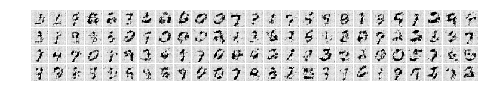

[1/15] - time: 0.416519 loss_d: 0.000977, loss_g: 0.001270


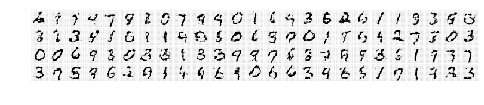

[2/15] - time: 0.194128 loss_d: 0.000870, loss_g: 0.001434


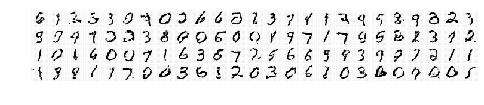

[3/15] - time: 0.202572 loss_d: 0.000851, loss_g: 0.001371


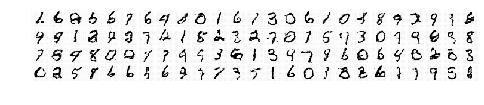

[4/15] - time: 0.191146 loss_d: 0.000794, loss_g: 0.001415


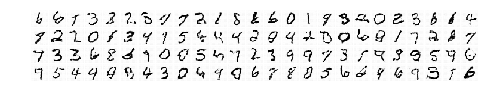

[5/15] - time: 0.188265 loss_d: 0.000769, loss_g: 0.001480


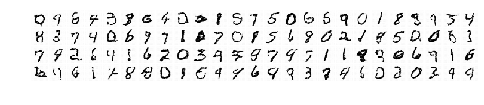

[6/15] - time: 0.203274 loss_d: 0.000723, loss_g: 0.001499


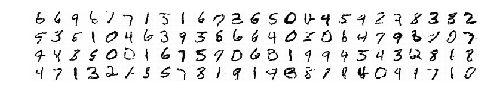

[7/15] - time: 0.185914 loss_d: 0.000691, loss_g: 0.001745


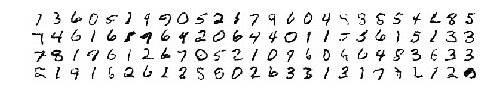

[8/15] - time: 0.186168 loss_d: 0.000710, loss_g: 0.001454


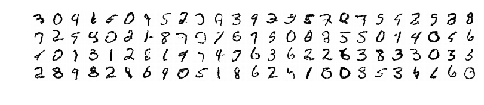

[9/15] - time: 0.181946 loss_d: 0.000663, loss_g: 0.001626


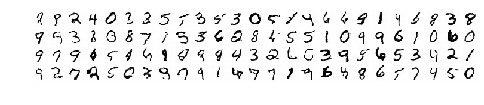

[10/15] - time: 0.181506 loss_d: 0.000650, loss_g: 0.001581


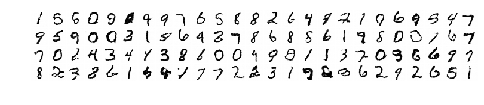

[11/15] - time: 0.185272 loss_d: 0.000657, loss_g: 0.001583


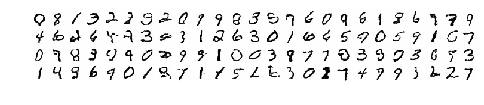

[12/15] - time: 0.185848 loss_d: 0.000622, loss_g: 0.001695


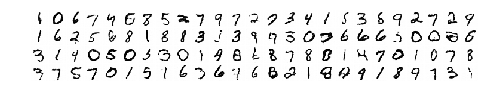

[13/15] - time: 0.188380 loss_d: 0.000556, loss_g: 0.001806


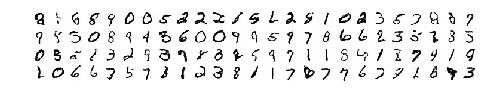

[14/15] - time: 0.181711 loss_d: 0.000545, loss_g: 0.001835


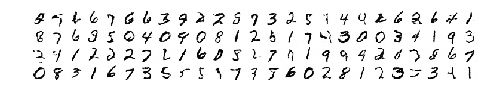

[15/15] - time: 0.176722 loss_d: 0.000559, loss_g: 0.001749


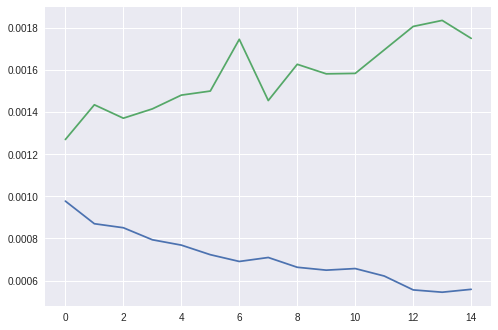

In [4]:
# Train the model
with tf.Session() as sess:
    
    # Initalize the variables
    sess.run(tf.global_variables_initializer())
    
    # Do the training process
    for epoch in range(num_epoch):
         
        # Train for each batch
        for idx in range(0, batch_idxs):
            batch_images = data[idx * batch_size:(idx + 1) * batch_size, :]
            batch_d_loss = batch_g_loss = 0
            epoch_start_time = time.time()
          
            # Sample the random values used to generate images
            z_sample = np.random.normal(size=(batch_size, 1, 1, z_dim))
            
            # Train the Discriminator
            sess.run(d_optim,{x:batch_images,z:z_sample,isTrain:True})
            # Calculate the Discriminator loss
            loss_d = sess.run(d_loss,{x:batch_images,z:z_sample,isTrain:True})
            # Train the Generator
            sess.run(g_optim,{x:batch_images,z:z_sample,isTrain:True})
            sess.run(g_optim,{x:batch_images,z:z_sample,isTrain:True})
            # Calculate the Generator loss
            loss_g = sess.run(g_loss,{x:batch_images,z:z_sample,isTrain:True})
            
            batch_d_loss += loss_d
            batch_g_loss += loss_g
    
        # Show the generated images
        sample_image = sess.run(gen, {z: z_sample, isTrain: False})
        output_image = img2cell(inverse_transform(sample_image))
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
    
        epoch_end_time = time.time()
        batch_d_loss /= batch_idxs
        batch_g_loss /= batch_idxs
        per_epoch_ptime = epoch_end_time - epoch_start_time
        print('[%d/%d] - time: %f loss_d: %f, loss_g: %f'
              % ((epoch + 1), num_epoch, per_epoch_ptime, batch_d_loss, batch_g_loss))
        train_hist['D_losses'].append(batch_d_loss)
        train_hist['G_losses'].append(batch_g_loss)
        train_hist['per_epoch_times'].append(per_epoch_ptime)
    plt.plot(train_hist['D_losses'])
    plt.plot(train_hist['G_losses'])
    plt.show()